### Transfer learning

Here we'll look at using the VGG-16 network, which is pre-trained from the ImageNet challenge data (http://www.image-net.org/challenges/LSVRC/), along with the transfer learning technique to train a classifier for MNIST. This is a bit of overkill for a simple dataset like MNIST, where creating our own network and training from scratch can make sense since we have many examples of each class, and the images are relatively small. Indeed in the last section we saw we can achieve 99% accuracy with a simple neural network. However, the same techniques can be applied to more complex datasets, which is left as a challenge to the reader at the bottom of this notebook.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split

In [2]:
### Here we load in all the relevant neural network packages ###
import tensorflow as tf

from keras.applications import xception, vgg16, vgg19, mobilenet
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras import optimizers
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Convolution2D, ZeroPadding2D, BatchNormalization, Input, concatenate
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.utils import np_utils, multi_gpu_model
from keras.optimizers import SGD, Adam
from keras.datasets import mnist
from keras import backend as K
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

/home/paperspace/anaconda3/envs/py27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import mnist

Let's import MNISt and do the same pre-processing of the data we did before to get it in an appropriate form.

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.reshape((60000,28,28,1))
x_test = x_test.reshape((10000,28,28,1))

In [5]:
y_train_enc = keras.utils.to_categorical(y_train)
y_test_enc = keras.utils.to_categorical(y_test)

### Define the processing parameters

In [6]:
batch_size = 128

We'll use the same scaling here, as VGG-16 wants to see images scaled in the same way with values from 0 to 1 as inputs.

In [7]:
### This is an example of a more complex data augmentation generator.
### Here we probably don't need it, so I leave it in case it is useful for the challenge
### at the bottom of the notebook
# train_datagen = ImageDataGenerator(
#         rotation_range=40,
#         rescale=1./255,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
        x_train,  
        y_train_enc,
        batch_size=batch_size)

# this is a similar generator, for validation data
validation_generator = test_datagen.flow(
        x_test,
        y_test_enc,
        batch_size=batch_size)

### Switch to transfer learning approach

In [8]:
#################################################################
############## Transfer Model 1 #################################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(28, 28, 1))
x = base_model.output

# Notice that we did not include the top of the neural network, which is the set of densely connected
# layers that where used to convert the output of the convolutional layers that find image features
# into the 1000 classes of the ImageNet dataset

### We need a normalization layer here to get the model output in a form we can send to a dense layer $$$
# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add fully-connected layers, using dropout as a way to keep the network
# from overfitting to the training data (regularization)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer, which will output probabilities from 0 to 1
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG-16 layers, which have already been trained
# to perform well on the ImageNet dataset
for layer in base_model.layers:
    layer.trainable = False

### We use adam as the optimizer. A few examples are commented out showing that we 
### can adjust many of the learning parameters of stochastic gradient descent if we want to
model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='categorical_crossentropy', metrics=["accuracy"])

ValueError: The input must have 3 channels; got `input_shape=(28, 28, 1)`

When we built our network up from scratch, we defined everything about our network, so the inputs could be whatever size we wanted. However, for transfer learning we must respect the original network size a bit more. VGG-16 was trained on 3-channel RGB images, and it needs to see those in order to function properly.

Our images only have one channel, so we'll just duplicate the image and it put copies of it in the second and third channels.

In [10]:
### Extract the current image parameters, define the new 3 channel shape ###
num_images, image_x, image_y, channels = x_train.shape
new_shape = (num_images, image_x, image_y, 3)
x_train_3c = np.zeros(new_shape) ## Empty array to hold the new 3 channel images

In [11]:
### Let's write the one channel images into the 3 empty channels of our new array ###
x_train_3c[:,:,:,0] = x_train[:,:,:,0]
x_train_3c[:,:,:,1] = x_train[:,:,:,0]
x_train_3c[:,:,:,2] = x_train[:,:,:,0]

In [12]:
#################################################################
############## Transfer Model 1 (Fixed) #########################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(28, 28, 3))
x = base_model.output

# Notice that we did not include the top of the neural network, which is the set of densely connected
# layers that where used to convert the output of the convolutional layers that find image features
# into the 1000 classes of the ImageNet dataset

### We need a normalization layer here to get the model output in a form we can send to a dense layer $$$
# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add fully-connected layers, using dropout as a way to keep the network
# from overfitting to the training data (regularization)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer, which will output probabilities from 0 to 1
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG-16 layers, which have already been trained
# to perform well on the ImageNet dataset
for layer in base_model.layers:
    layer.trainable = False

### We use adam as the optimizer. A few examples are commented out showing that we 
### can adjust many of the learning parameters of stochastic gradient descent if we want to
model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='categorical_crossentropy', metrics=["accuracy"])

ValueError: Input size must be at least 48x48; got `input_shape=(28, 28, 3)`

Now we have the correct number of channels, but the model can't take images at that low of resolution. With a bit of work we can get around this, let's hope it's worth it in the end! This took a bit of figuring with SciPy's two-dimensional interpolation function, please see the associated docs here: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html

In [13]:
from scipy.interpolate import interp2d

In [14]:
#### This all took about 30 seconds to run on the Paperspace VM ####

### Get the original image indices in x and y ###
orig_x_ind = range(image_x)
orig_y_ind = range(image_y)

### Create a grid of new values, with points interpolated between ###
new_x_values = np.arange(0, image_x, 0.5)
new_y_values = np.arange(0, image_y, 0.5)

### Create an empty array with enough space to hold the new grid ###
new_shape_exp = (num_images, len(new_x_values), len(new_y_values), 3)
x_train_3c_exp = np.zeros(new_shape_exp)

### Iterate through the images, interpolating for each one on the new grid ###
for i in range(x_train.shape[0]):
    ### Extract the interpolation function for this particular image ###
    interp_fn = interp2d(orig_x_ind, orig_y_ind, x_train[i,:,:,0])
    
    ### Perform the interpolation ###
    interp_image = interp_fn(new_x_values, new_y_values)
    
    ### Put the interpolated image into each of the three channels ###
    x_train_3c_exp[i, :, :, 0] = interp_image 
    x_train_3c_exp[i, :, :, 1] = interp_image 
    x_train_3c_exp[i, :, :, 2] = interp_image 

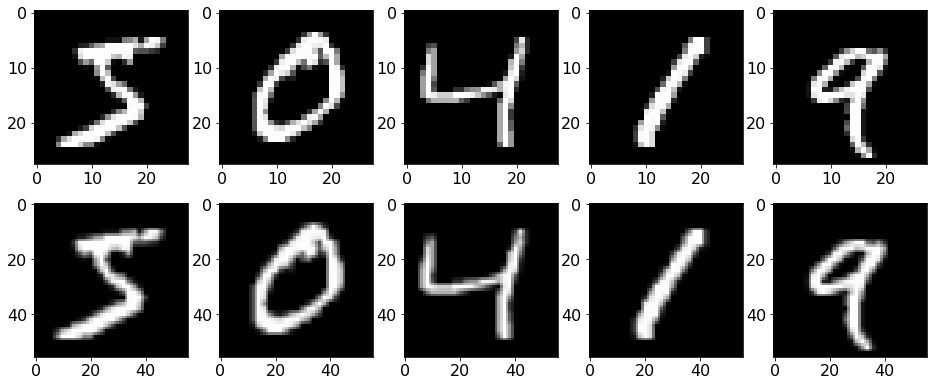

In [15]:
### Let's check out a sample of our new interpolated/higher-resolution images ###
plt.figure(figsize=(16,6.5))
num_images = 5
for i in range(num_images):
    plt.subplot(2,num_images,i+1); 
    plt.imshow(x_train_3c[i,:,:,0], cmap='gray')
    
    plt.subplot(2,num_images,num_images + i + 1); 
    plt.imshow(x_train_3c_exp[i,:,:,0], cmap='gray')

This seems to have worked, let's not forget to do it for the test set as well.

In [17]:
#### Image interpolation for the test image set ###
num_images_test = x_test.shape[0]
new_shape_test_exp = (num_images_test, len(new_x_values), len(new_y_values), 3)

x_test_3c_exp = np.zeros(new_shape_test_exp)

for i in range(x_test.shape[0]):
    
    interp_fn = interp2d(orig_x_ind, orig_y_ind, x_test[i,:,:,0])
    
    interp_image = interp_fn(new_x_values, new_y_values)
    
    x_test_3c_exp[i, :, :, 0] = interp_image 
    x_test_3c_exp[i, :, :, 1] = interp_image 
    x_test_3c_exp[i, :, :, 2] = interp_image 

OK, so now we have our high resolution interpolated images. Let's run the transfer model and see if it was all worth it.

In [16]:
#################################################################
############## Transfer Model 1 (Fixed+) #########################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(56, 56, 3))
x = base_model.output

# Notice that we did not include the top of the neural network, which is the set of densely connected
# layers that where used to convert the output of the convolutional layers that find image features
# into the 1000 classes of the ImageNet dataset

### We need a normalization layer here to get the model output in a form we can send to a dense layer $$$
# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add fully-connected layers, using dropout as a way to keep the network
# from overfitting to the training data (regularization)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer, which will output probabilities from 0 to 1
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG-16 layers, which have already been trained
# to perform well on the ImageNet dataset
for layer in base_model.layers:
    layer.trainable = False

### We use adam as the optimizer. A few examples are commented out showing that we 
### can adjust many of the learning parameters of stochastic gradient descent if we want to
model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='categorical_crossentropy', metrics=["accuracy"])

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
        x_train_3c_exp,  
        y_train_enc,
        batch_size=batch_size)

In [19]:
history = model_transfer.fit_generator(train_generator, x_train_3c_exp.shape[0] // batch_size, \
                                    epochs=20, verbose=1, validation_data=(x_test_3c_exp, y_test_enc))
model_transfer.save_weights('./models/transfer_architecture_1.h5')
pd.DataFrame(history.history).to_csv('./models/transfer_architecture_1.csv', index=True)

Epoch 1/20
468/468 [==============================] - 30s 65ms/step - loss: 0.2959 - acc: 0.9037 - val_loss: 6.5087 - val_acc: 0.5665
Epoch 2/20
468/468 [==============================] - 27s 58ms/step - loss: 0.1275 - acc: 0.9595 - val_loss: 6.1298 - val_acc: 0.5971
Epoch 3/20
468/468 [==============================] - 28s 59ms/step - loss: 0.1036 - acc: 0.9667 - val_loss: 6.8053 - val_acc: 0.5547
Epoch 4/20
468/468 [==============================] - 27s 59ms/step - loss: 0.0957 - acc: 0.9698 - val_loss: 6.6710 - val_acc: 0.5638
Epoch 5/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0887 - acc: 0.9723 - val_loss: 6.3803 - val_acc: 0.5859
Epoch 6/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0794 - acc: 0.9741 - val_loss: 7.2782 - val_acc: 0.5296
Epoch 7/20
468/468 [==============================] - 28s 59ms/step - loss: 0.0767 - acc: 0.9758 - val_loss: 6.8739 - val_acc: 0.5555
Epoch 8/20
468/468 [==============================] - 28s 59ms

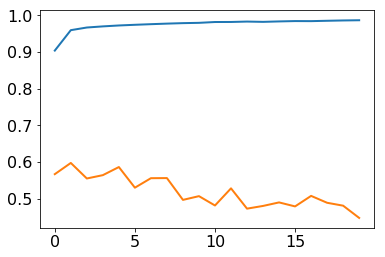

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

That didn't go so well! However, we have not allowed any of the convolutional parts of the network to be trainable. Since this network was pre-trained on ImageNet, the shapes of the final layers may encode shapes that are very complex, and very different than the simple numbers we have. Let's look at the layers of the VGG-16 network.

In [21]:
print(len(base_model.layers))
base_model.layers

19


Let's target making everything trainable in the final convolution/pooling layers, i.e. this is frozen, and everything else is trainable:

In [22]:
base_model.layers[:15]

In [23]:
#################################################################
############## Transfer Model 2 #################################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(56, 56, 3))
x = base_model.output

# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

freeze_layer = 15

### Freeze layers ###
for layer in base_model.layers[:freeze_layer]:
    layer.trainable = False

### Trainable layers ###
for layer in base_model.layers[freeze_layer:]:
    layer.trainable = True

model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='categorical_crossentropy', metrics=["accuracy"])

In [24]:
history = model_transfer.fit_generator(train_generator, x_train_3c_exp.shape[0] // batch_size, \
                                    epochs=20, verbose=1, validation_data=(x_test_3c_exp, y_test_enc))
model_transfer.save_weights('./models/transfer_architecture_2.h5')
pd.DataFrame(history.history).to_csv('./models/transfer_architecture_2.csv', index=True)

Epoch 1/20
468/468 [==============================] - 35s 76ms/step - loss: 0.1414 - acc: 0.9594 - val_loss: 0.3925 - val_acc: 0.9738
Epoch 2/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0570 - acc: 0.9875 - val_loss: 0.4932 - val_acc: 0.9676
Epoch 3/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0473 - acc: 0.9899 - val_loss: 0.3658 - val_acc: 0.9762
Epoch 4/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0393 - acc: 0.9917 - val_loss: 0.7295 - val_acc: 0.9518
Epoch 5/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0425 - acc: 0.9920 - val_loss: 0.3251 - val_acc: 0.9793
Epoch 6/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0489 - acc: 0.9915 - val_loss: 0.4829 - val_acc: 0.9699
Epoch 7/20
468/468 [==============================] - 35s 75ms/step - loss: 0.0445 - acc: 0.9924 - val_loss: 0.2454 - val_acc: 0.9838
Epoch 8/20
468/468 [==============================] - 35s 75ms

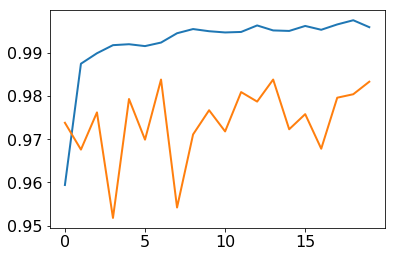

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

We did a lot better there. Let's release a few more of the layers to be trainable, and see how we do.

In [26]:
base_model.layers[:11]

In [27]:
#################################################################
############## Transfer Model 3 #################################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(56, 56, 3))
x = base_model.output

# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

freeze_layer = 11

### Freeze layers ###
for layer in base_model.layers[:freeze_layer]:
    layer.trainable = False

### Trainable layers ###
for layer in base_model.layers[freeze_layer:]:
    layer.trainable = True

model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='categorical_crossentropy', metrics=["accuracy"])

In [28]:
history = model_transfer.fit_generator(train_generator, x_train_3c_exp.shape[0] // batch_size, \
                                    epochs=20, verbose=1, validation_data=(x_test_3c_exp, y_test_enc))
model_transfer.save_weights('./models/transfer_architecture_3.h5')
pd.DataFrame(history.history).to_csv('./models/transfer_architecture_3.csv', index=True)

Epoch 1/20
468/468 [==============================] - 46s 99ms/step - loss: 0.6518 - acc: 0.7647 - val_loss: 0.4430 - val_acc: 0.9718
Epoch 2/20
468/468 [==============================] - 45s 96ms/step - loss: 0.0743 - acc: 0.9842 - val_loss: 0.4130 - val_acc: 0.9711
Epoch 3/20
468/468 [==============================] - 46s 98ms/step - loss: 0.0544 - acc: 0.9888 - val_loss: 0.2887 - val_acc: 0.9798
Epoch 4/20
468/468 [==============================] - 46s 98ms/step - loss: 0.0468 - acc: 0.9908 - val_loss: 0.9484 - val_acc: 0.9334
Epoch 5/20
468/468 [==============================] - 46s 98ms/step - loss: 0.0525 - acc: 0.9904 - val_loss: 0.2706 - val_acc: 0.9825
Epoch 6/20
468/468 [==============================] - 46s 98ms/step - loss: 0.0578 - acc: 0.9890 - val_loss: 0.3203 - val_acc: 0.9792
Epoch 7/20
468/468 [==============================] - 46s 98ms/step - loss: 0.0465 - acc: 0.9917 - val_loss: 0.3042 - val_acc: 0.9800
Epoch 8/20
468/468 [==============================] - 46s 99ms

(0.95, 1.0)

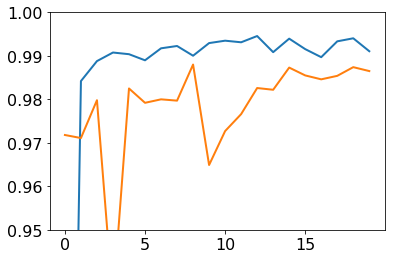

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylim([0.95,1.0])

That seems to have gotten even better, let's continue unfreezing layers. Notice that the training time per epoch is increasing, as we allow more layer weights to be adjustable and the model must learn more.

In [32]:
base_model.layers[:7]

In [33]:
#################################################################
############## Transfer Model 4 #################################
#################################################################

# create the base pre-trained model
# base_model = xception.Xception(weights='imagenet', include_top=False, input_shape=(75,75,3))
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(56, 56, 3))
x = base_model.output

# x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# x = GlobalMaxPooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)

# And the final softmax layer
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_transfer = Model(inputs=base_model.input, outputs=predictions)

freeze_layer = 7

### Freeze layers ###
for layer in base_model.layers[:freeze_layer]:
    layer.trainable = False

### Trainable layers ###
for layer in base_model.layers[freeze_layer:]:
    layer.trainable = True

model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=["accuracy"])
# model.compile(optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True, decay=1e-6), \
#               loss='categorical_crossentropy', metrics=["accuracy"])

In [34]:
history = model_transfer.fit_generator(train_generator, x_train_3c_exp.shape[0] // batch_size, \
                                    epochs=20, verbose=1, validation_data=(x_test_3c_exp, y_test_enc))
model_transfer.save_weights('./models/transfer_architecture_4.h5')
pd.DataFrame(history.history).to_csv('./models/transfer_architecture_4.csv', index=True)

Epoch 1/20
468/468 [==============================] - 56s 119ms/step - loss: 2.3027 - acc: 0.1113 - val_loss: 2.3016 - val_acc: 0.1135
Epoch 2/20
468/468 [==============================] - 55s 117ms/step - loss: 2.3014 - acc: 0.1121 - val_loss: 2.3014 - val_acc: 0.1135
Epoch 3/20
468/468 [==============================] - 55s 117ms/step - loss: 2.3014 - acc: 0.1123 - val_loss: 2.3013 - val_acc: 0.1135
Epoch 4/20
468/468 [==============================] - 55s 118ms/step - loss: 2.3013 - acc: 0.1125 - val_loss: 2.3010 - val_acc: 0.1135
Epoch 5/20
468/468 [==============================] - 55s 118ms/step - loss: 2.3014 - acc: 0.1125 - val_loss: 2.3011 - val_acc: 0.1135
Epoch 6/20
468/468 [==============================] - 55s 118ms/step - loss: 2.3014 - acc: 0.1122 - val_loss: 2.3011 - val_acc: 0.1135
Epoch 7/20
468/468 [==============================] - 55s 118ms/step - loss: 2.3013 - acc: 0.1125 - val_loss: 2.3011 - val_acc: 0.1135
Epoch 8/20
468/468 [==============================] - 5

Suddenly, the model isn't able to learn at all! Training neural networks that are very deep, where all layers are trainable, it can sometimes be difficult to get the system to converge to a useful solution. We should probably go with our previous solution, or else use our small from-scratch network for this MNIST dataset. For a more complicated dataset, especially as we start to get more complex images and more classes, the transfer learning approach will really start to outdo the small from-stratch approach.

### Exercise for the reader

Download the Kaggle data for the cats and dogs dataset using their API: https://github.com/Kaggle/kaggle-api

Competition information for cats vs dogs here: https://www.kaggle.com/c/dogs-vs-cats/rules

Challenge: create a transfer learning model that can distinguish cats vs. dogs using vgg-16 or another pre-trained model of your choice from the Keras library.